## Computer Vision Example

In [1]:
import os
import io
import boto3
import re
import copy
import struct
import csv
import time
from time import gmtime, strftime
from sagemaker import get_execution_role

import pickle, gzip, urllib.request, json
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (2,10)

In [2]:
%%time 
# Retrieves the IAM role created when the notebook instance was created.
role = get_execution_role()

region = boto3.Session().region_name

# Replace with our s3 bucket name
bucket='sagemaker-computer-vision' 
# Used as part of the path in the bucket where our store data
prefix = 'sagemaker/xgboost-mnist' 
# The URL to access the bucket
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket) 

CPU times: user 81.6 ms, sys: 15.3 ms, total: 96.9 ms
Wall time: 882 ms


### Download the MNIST Dataset

Reads the following datasets into the notebook's memory:
- train_set – Use these images of handwritten numbers to train a model.

- valid_set – The XGBoost Algorithm uses these images to evaluate the progress of the model during training.

- test_set – Use this set to get inferences to test the deployed model.

In [3]:
# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")

with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

print(train_set[0].shape)

(50000, 784)


### Explore the Training Dataset

train_set contains the following structures:

- train_set[0] – Contains images.

- train_set[1] – Contains labels.

This is a 5


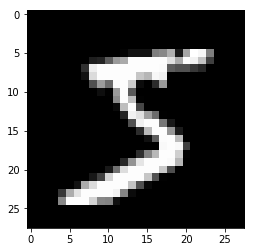

This is a 0


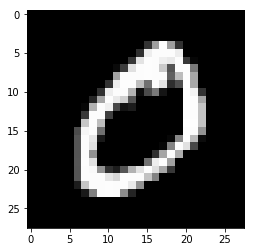

This is a 4


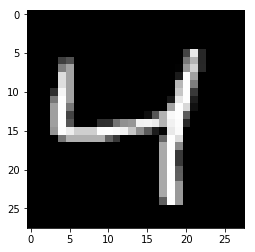

This is a 1


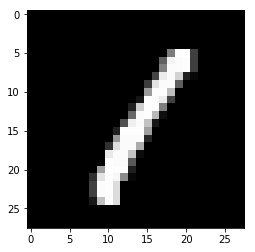

This is a 9


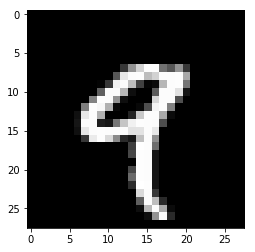

This is a 2


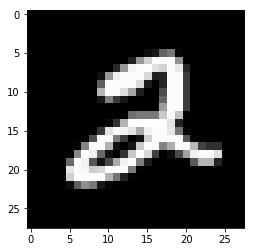

This is a 1


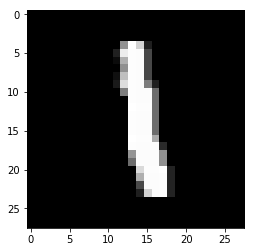

This is a 3


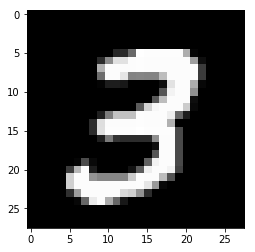

This is a 1


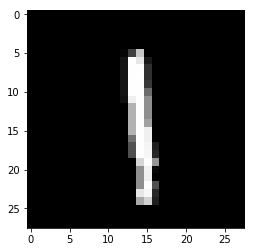

This is a 4


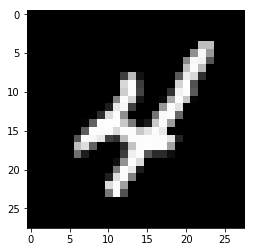

In [5]:
# Display the first 10 images from the training dataset
for i in range(0, 10):
    img = train_set[0][i] # ith image 
    label = train_set[1][i] # label of ith image
    img_reshape = img.reshape((28,28)) # reshape to smaller dimension
    imgplot = plt.imshow(img_reshape, cmap='gray') # convert to gray-scale
    print('This is a {}'.format(label)) # print label value of image
    plt.show()

### Transform the Training Dataset and Upload It to Amazon S3

The XGBoost Algorithm expects comma-separated values (CSV) for its training input. The format of the training dataset is numpy.array. We transform the dataset from numpy.array format to the CSV format. Then upload it to the Amazon S3 bucket.

In [7]:
def convert_data():
    data_partitions = [('train', train_set), 
                       ('validation', valid_set), 
                       ('test', test_set)]
    
    for data_partition_name, data_partition in data_partitions:
        print('{}: {} {}'.format(data_partition_name, data_partition[0].shape, data_partition[1].shape))
        labels = [t.tolist() for t in data_partition[1]]
        features = [t.tolist() for t in data_partition[0]]
        
        if data_partition_name != 'test':
            examples = np.insert(features, 0, labels, axis=1)
        else:
            examples = features
        #print(examples[50000,:])
        
        
        np.savetxt('data.csv', examples, delimiter=',')
        
        # Upload dataset to the Amazon S3 bucket
        key = "{}/{}/examples".format(prefix, data_partition_name)
        url = 's3://{}/{}'.format(bucket, key)
        boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_file('data.csv')
        print('Done writing to {}'.format(url))

In [8]:
%%time 
convert_data()

train: (50000, 784) (50000,)
Done writing to s3://sagemaker-computer-vision/sagemaker/xgboost-mnist/train/examples
validation: (10000, 784) (10000,)
Done writing to s3://sagemaker-computer-vision/sagemaker/xgboost-mnist/validation/examples
test: (10000, 784) (10000,)
Done writing to s3://sagemaker-computer-vision/sagemaker/xgboost-mnist/test/examples
CPU times: user 38.1 s, sys: 6.09 s, total: 44.2 s
Wall time: 58.5 s


### Train a Model
To train, deploy, and validate a model in Amazon SageMaker, we can use either the Amazon SageMaker Python SDK (or AWS SDK for Python (Boto 3))

In [9]:
# Import the Amazon SageMaker Python SDK and get the XGBoost container
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri

# There is a more up to date SageMaker XGBoost image, set 'repo_version'='0.90-1
container = get_image_uri(boto3.Session().region_name, 'xgboost', '0.90-1')

In [10]:
# Download the training and validation data from the Amazon S3 location where it was uploaded.
train_data = 's3://{}/{}/{}'.format(bucket, prefix, 'train')

validation_data = 's3://{}/{}/{}'.format(bucket, prefix, 'validation')

s3_output_location = 's3://{}/{}/{}'.format(bucket, prefix, 'xgboost_model_sdk')
print(train_data)

s3://sagemaker-computer-vision/sagemaker/xgboost-mnist/train


In [11]:
# Create an instance of the sagemaker.estimator.Estimator class
xgb_model = sagemaker.estimator.Estimator(container,
                                         role, # AWS Identity and Access Management (IAM) role that Amazon SageMaker can assume to perform tasks on our behalf (read/write on S3)
                                         train_instance_count=1, # The type and number of ML compute instances to use for model training. 
                                         train_instance_type='ml.m4.xlarge',
                                         train_volume_size = 5, # The size, in GB, of the Amazon Elastic Block Store (Amazon EBS) storage volume to attach to the training instance. This must be large enough to store training data if we use File mode (File mode is the default).
                                         output_path=s3_output_location, # The path to the S3 bucket where Amazon SageMaker stores the training results.
                                         sagemaker_session=sagemaker.Session() #  The session object that manages interactions with Amazon SageMaker APIs and any other AWS service that the training job uses.
                                         )

In [12]:
# Set the hyperparameter values for the XGBoost training job 
xgb_model.set_hyperparameters(max_depth = 5,
                              eta = .2,
                              gamma = 4,
                              min_child_weight = 6,
                              silent = 0,
                              objective = "multi:softmax",
                              num_class = 10,
                              num_round = 10)

In [13]:
# Create the training channels to use for the training job and validation job. 
train_channel = sagemaker.session.s3_input(train_data, content_type='text/csv')
valid_channel = sagemaker.session.s3_input(validation_data, content_type='text/csv')

data_channels = {'train': train_channel, 'validation': valid_channel}

Training model is a synchronous operation. The method displays progress logs and waits until training completes before returning.

In [14]:
# To start model training,
xgb_model.fit(inputs=data_channels,  logs=True)

2019-10-27 00:18:24 Starting - Starting the training job...
2019-10-27 00:18:25 Starting - Launching requested ML instances...
2019-10-27 00:19:24 Starting - Preparing the instances for training......
2019-10-27 00:20:13 Downloading - Downloading input data......
2019-10-27 00:21:11 Training - Downloading the training image..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value multi:softmax to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[00:21:37] 50000x784 matrix with 39200000 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:root:Determined delimiter 

### Deploy the Model to Amazon SageMaker Hosting Services

The deploy method creates the deployable model, configures the Amazon SageMaker hosting services endpoint, and launches the endpoint to host the model. It also returns a sagemaker.predictor.RealTimePredictor object, which we can use to get inferences from the model.

In [15]:
# Deploy the model that we trained in Create and Run a Training Job with Amazon SageMaker Python SDK by calling the deploy method of the sagemaker.
xgb_predictor = xgb_model.deploy(initial_instance_count=1,
                                instance_type='ml.m4.xlarge',
                                )

-------------------------------------------------------------------------------------!

### Validate the Model

Now that we have trained and deployed a model in Amazon SageMaker, validate it to ensure that it generates accurate predictions on new data. That is, on data that is different from the data that the model was trained on. For this, we use the test dataset.

now have an endpoint, since we deployed a model to Amazon SageMaker hosting services, that we can invoke to get inferences in real time. To validate the model, invoke the endpoint with example images from the test dataset and check whether the inferences we get match the actual labels of the images.

AWS SageMaker currently supports two kinds of deployment: deploying your model as a web endpoint, or using the model to perform a batch job.

In [16]:
# Download the test data from Amazon S3
s3 = boto3.resource('s3')

test_key = "{}/test/examples".format(prefix)

s3.Bucket(bucket).download_file(test_key, 'test_data')

This is a 7


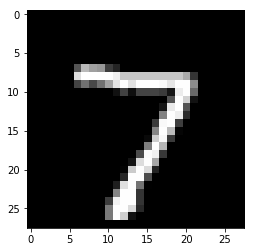

This is a 2


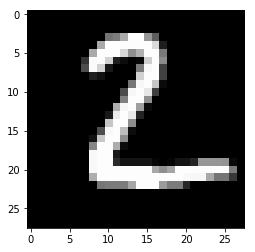

This is a 1


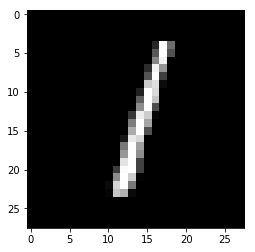

This is a 0


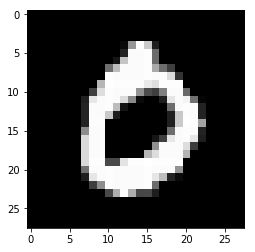

This is a 4


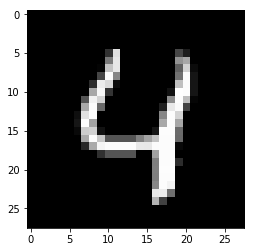

This is a 1


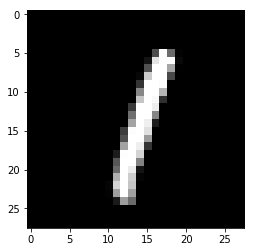

This is a 4


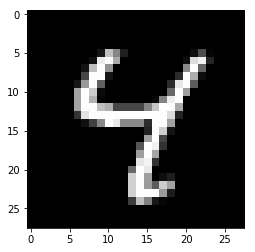

This is a 9


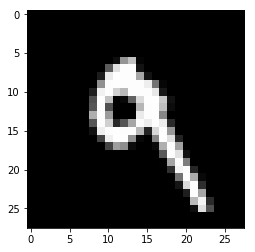

This is a 5


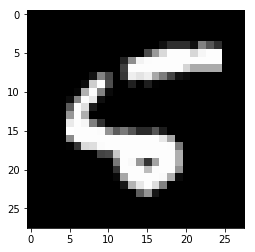

This is a 9


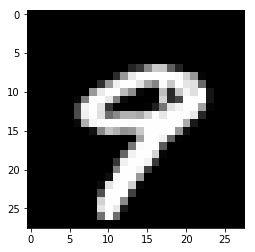

In [17]:
# Plot the first 10 images from the test dataset with their labels
%matplotlib inline
                        
for i in range (0, 10):
    img = test_set[0][i]
    label = test_set[1][i]
    img_reshape = img.reshape((28,28))
    imgplot = plt.imshow(img_reshape, cmap='gray')
    print('This is a {}'.format(label))
    plt.show()

To see if the model is making accurate predictions, check the output from this step against the numbers that you plotted in the previous step.

In [19]:
# To get inferences for the first 10 examples in the test dataset, call the predict method of the sagemaker.predictor.RealTimePredictor object.
with open('test_data', 'r') as f:
    for j in range(0,10):
        single_test = f.readline()
        result = xgb_predictor.predict(single_test)
        print(result)

b'7.0'
b'2.0'
b'1.0'
b'0.0'
b'4.0'
b'1.0'
b'4.0'
b'9.0'
b'5.0'
b'9.0'


In a production environment, you might have an internet-facing application sending requests to the endpoint for inference. how to integrate your model endpoint into your application.

- Create an IAM role that the AWS Lambda service principal can assume. Give the role permissions to call the Amazon SageMaker InvokeEndpoint API.

- Create a Lambda function that calls the Amazon SageMaker InvokeEndpoint API.

- Call the Lambda function from a mobile application. For an example of how to call a Lambda function from a mobile application using Amazon Cognito for credentials

### Validate a Model Deployed with Batch Transform

To validate the batch transform inferences

In [ ]:
# Deploy a Model with Batch Transform
batch_input =  's3://{}/{}/test/examples'.format(bucket, prefix) # The location of the test dataset

batch_output = 's3://{}/{}/batch-inference'.format(bucket, prefix) # The location to store the results of the batch transform job

transformer = xgb_model.transformer(instance_count=1, instance_type='ml.m4.xlarge', output_path=batch_output)

transformer.transform(data=batch_input, data_type='S3Prefix', content_type='text/csv', split_type='Line')

transformer.wait()

Using already existing model: sagemaker-xgboost-2019-10-27-00-18-24-386


.....................[2019-10-27 00:33:38 +0000] [15] [INFO] Starting gunicorn 19.9.0
[2019-10-27 00:33:38 +0000] [15] [INFO] Listening at: unix:/tmp/gunicorn.sock (15)
[2019-10-27 00:33:38 +0000] [15] [INFO] Using worker: gevent
[2019-10-27 00:33:38 +0000] [22] [INFO] Booting worker with pid: 22
[2019-10-27 00:33:38 +0000] [23] [INFO] Booting worker with pid: 23
[2019-10-27 00:33:38 +0000] [27] [INFO] Booting worker with pid: 27
[2019-10-27 00:33:38 +0000] [28] [INFO] Booting worker with pid: 28
[2019-10-27:00:33:44:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [27/Oct/2019:00:33:44 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
[2019-10-27:00:33:44:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [27/Oct/2019:00:33:44 +0000] "GET /execution-parameters HTTP/1.1" 200 84 "-" "Go-http-client/1.1"


In [ ]:
# Download the test data from Amazon S3
s3 = boto3.resource('s3')

test_key = "{}/test/examples".format(prefix)

s3.Bucket(bucket).download_file(test_key, 'test_data')

In [ ]:
%matplotlib inline

# Plot the first 10 images from the test dataset with their labels                   
for i in range (0, 10):
    img = test_set[0][i]
    label = test_set[1][i]
    img_reshape = img.reshape((28,28))
    imgplot = plt.imshow(img_reshape, cmap='gray')
    print('This is a {}'.format(label))
    plt.show()

In [ ]:
# Download the output from the batch transform job from Amazon S3 to a local file
s3.Bucket(bucket).download_file(prefix + '/batch-inference/examples.out',  'batch_results')

In [ ]:
# Get the first 10 results from the batch transform job
with open('batch_results') as f:
    results = f.readlines()
for j in range (0, 10):
    print(results[j])

In [ ]:
!git status

In [ ]:
!git pull origin master

In [ ]:
!git add mnist_dataset.ipynb

In [ ]:
!git config --global user.name chrisjcc
!git config --global user.email chrisjcc.physics@gmail.com

In [ ]:
!git commit -m 'add AWS SageMaker jupyter notebook running xgboost on MNIST dataset'

In [ ]:
#!git commit -m 'add AWS SageMaker jupyter notebook running xgboost on MNIST dataset' mnist_dataset.ipynb

In [ ]:
!git push origin master